# Import Libraries

### Resources
[First Video PyOhio](https://www.youtube.com/watch?v=xvqsFTUsOmc)

Pace your own course through chunks of topics below:


Simple approach to any NLP Problem: https://www.kaggle.com/code/littleraj30/simple-approach-to-any-nlp-problem/notebook#2.-Text-based-feature  

Topic modelling:  
1) https://www.youtube.com/watch?v=3mHy4OSyRf0&t=515s  
2) https://www.kaggle.com/code/dskswu/topic-modeling-bert-lda  
3) https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925  
4) https://medium.com/data-folks-indonesia/recent-works-in-topic-modeling-56c38da8dfc4  

Language Modeling:  
1) https://www.youtube.com/watch?v=GiyMGBuu45w&ab_channel=MachineLearningTV  
2) https://towardsdatascience.com/the-beginners-guide-to-language-models-aa47165b57f9  
3) https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-language-model-nlp-python-code/  
4) https://machinelearningmastery.com/statistical-language-modeling-and-neural-language-models/  
5) https://colab.research.google.com/github/fastai/fastbook/blob/master/10_nlp.ipynb  
6) https://medium.com/apache-mxnet/handwriting-ocr-handwriting-recognition-and-language-modeling-with-mxnet-gluon-4c7165788c67 

  
Text Translation:  
1) https://www.youtube.com/watch?v=nRBnh4qbPHI&ab_channel=SirajRaval  
1.1) https://machinelearningmastery.com/introduction-neural-machine-translation/  
2) https://github.com/PavelOstyakov/toxic/tree/master/tools  
3) https://www.kaggle.com/code/adnanzaidi/encode-decode-translation/notebook  
4) https://www.kaggle.com/code/adnanzaidi/simple-lstm-for-text-classification  
5) https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571  

Text Generation:  
1) https://www.youtube.com/watch?v=VAMKuRAh2nc&t=7s  
2) https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms  
3) https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e  
4) https://www.kaggle.com/code/mrisdal/intro-to-lstms-w-keras-gpu-for-text-generation  
5) https://www.kaggle.com/code/tuckerarrants/text-generation-with-huggingface-gpt2  

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline


from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import joblib

import shap

In [88]:
import tensorflow as tf    
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Import Data & Explore

In [2]:
data = pd.read_csv("US_Elections_2020.csv").drop(columns=['negative_reason'])

In [3]:
data

,text,sentiment
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0
3,b'Every 107 seconds an American is dying from ...,1
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1
...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1
2548,b'@nowthisnews Delivered today in Montgomery C...,1
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0


In [4]:
data['text'].sample(1).values[0]

"b'November 3rd is the last day to vote! Use your vote, use your voice to get Trump out of office. This election is https://t.co/LTmQYmfIDD'"

In [5]:
data['text'].sample(1).values[0]

"b'#KAG #MAGA #TCOT #Trump2020 #CCOT\\nEveryone MUST VOTE for #TRUMP2020ToSaveAmerica \\n#SilentMajority https://t.co/BBNC8qTswb'"

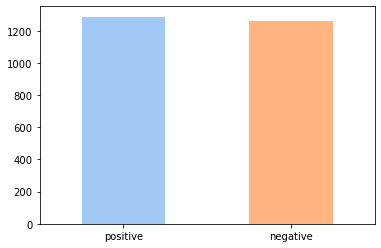

In [104]:
data['sentiment'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['positive', 'negative'], rotation=0);

# Data EDA & Preprocessing (Cleaning and Inspecting)

In [15]:
data.isna().sum()

text         0
sentiment    0
dtype: int64

### Text character-wise cleaning

In [7]:
def change_case_lower(text):
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    
    return sample

def remove_url(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    
    return sample

def remove_html(text):
    sample = text
    comp = re.compile(r'<.*?>')
    sample = re.sub(comp, '', sample)
    
    return sample

def remove_punctuations(text):
    sample = text
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    
    return sample

only_english = set(nltk.corpus.words.words())
def remove_special_characters(text):
    sample = text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

def remove_hashtags_total(text):
    sample = text
    sample = re.sub('#', ' ', sample)
    
    return sample

def remove_hashtags_only(text):
    sample = text
    sample = ' '.join([x for x in s.split() if not x.startswith('#')])
    
    return sample

def remove_emojis(text):
    sample = text
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    return sample

In [136]:
s = """@DrBiden Ask Joe about his thoughts <b> on packing </b> the Supreme Court. 😅😄 He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl"""
s

'@DrBiden Ask Joe about his thoughts <b> on packing </b> the Supreme Court. 😅😄 He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**URLs and Hyperlinks**

In [56]:
remove_url(s)

'@DrBiden Ask Joe about his thoughts on packing the Supreme Court. 😅😄 He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and '

**remove HTML Tags**

In [146]:
remove_html(s)

'@DrBiden Ask Joe about his thoughts  on packing  the Supreme Court. 😅😄 He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**punctuations**

In [57]:
remove_punctuations(s)

'DrBiden Ask Joe about his thoughts on packing the Supreme Court 😅😄 He seem to have any after 50 years in politics JoeBiden more sinister nnCovid19UK nCovid News nnJust enter empty testing stations СВОИМИ РУКАМИ into your search engIne and httpstcoomPuIJzVnl'

**lowercase**

In [81]:
change_case_lower(s)

'@drbiden ask joe about his thoughts on packing the supreme court. 😅😄 he seem to have any after 50 years in politics. #joebiden ...more sinister" \\n\\n#covid19uk \\n#covid #news \\n\\njust enter "empty testing stations" своими руками into your search engine and https://t.co/ompuijzvnl'

**special characters like non-english languages, whitespace**

In [369]:
remove_special_characters(s)

'Ask Joe about his b on b the Supreme Court He seem to have any after in politics more sinister Covid19UK Covid News Just enter empty testing into your search engIne and t'

**hashtags**

In [63]:
remove_hashtags_total(s)

'@DrBiden Ask Joe about his thoughts on packing the Supreme Court. 😅😄 He seem to have any after 50 years in politics.  JoeBiden ...more sinister" \\n\\n Covid19UK \\n Covid  News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**emojis**

In [64]:
remove_emojis(s)

'@DrBiden Ask Joe about his thoughts on packing the Supreme Court.  He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**COMPILING EVERYTHNG WITH IN-ORDER CONTEXT**

In [8]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [9]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))
data

,text,sentiment,cleaned_text
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,so afraid of and even if to do even more damag...
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,lord sumption recovery a new initiative to pro...
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,timing after said they would put pressure on b...
3,b'Every 107 seconds an American is dying from ...,1,an is dying from the that is a
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,the embrace for all that make our nation what ...
...,...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1,it is one citizen i call for the removal from ...
2548,b'@nowthisnews Delivered today in Montgomery C...,1,today in county pa
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0,lied on fox when he said the number of covid i...
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0,any why is wasting time in this close to the e...


honest Honest

Word forms 
go <= going went gone
Verb

### Text word-wise cleaning

**stop words**  

Stop words are available in abundance in any human language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information. In order words, we can say that the removal of such words does not show any negative consequences on the model we train for our task.
Removal of stop words definitely reduces the dataset size and thus reduces the training time due to the fewer number of tokens involved in the training.  

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.  

**parts-of-speech-tagging**

<code>from nltk.corpus import wordnet
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
</code>


  
    

**stemming vs lemmatizing**  

Stemming and Lemmatization are text normalization techniques.  

Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.
Often when searching text for a certain keyword, it helps if the search returns variations of the word. For instance, searching for “boat” might also return “boats” and “boating”. Here, “boat” would be the stem for [boat, boater, boating, boats].   

In contrast to stemming, lemmatization looks beyond word reduction and considers a language’s full vocabulary to apply a morphological analysis to words. The lemma of ‘was’ is ‘be’ and the lemma of ‘mice’ is ‘mouse’.
Lemmatization is typically seen as much more informative than simple stemming, which is why Spacy has opted to only have Lemmatization available instead of Stemming

>Stemming and Lemmatization both generate the foundation sort of the inflected words and therefore the only difference is that stem may not be an actual word whereas, lemma is an actual language word.
Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used a corpus also to supply lemma which makes it slower than stemming. you furthermore might had to define a parts-of-speech to get the proper lemma.

boys were playing

boy were play  
boys be play

In [10]:
# Caching stopwords outside for better speed
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample


# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample


# Stemming the data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

def correct_spelling(text):
    
    sample = text
    sample = str(TextBlob(text).correct())
    
    return sample

In [85]:
s

'@DrBiden Ask Joe about his thoughts on packing the Supreme Court. 😅😄 He seem to have any after 50 years in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**stop words**

In [66]:
remove_stop_words(s)

'@drbiden ask joe thoughts packing supreme court. 😅😄 seem 50 years politics. #joebiden ...more sinister" \\n\\n#covid19uk \\n#covid #news \\n\\njust enter "empty testing stations" своими руками search engine https://t.co/ompuijzvnl'

**stemming**

In [84]:
stem_clean_text(s)

'@drbiden ask joe about hi thought on pack the suprem court. 😅😄 He seem to have ani after 50 year in politics. #joebiden ...more sinister" \\n\\n#covid19uk \\n#covid #new \\n\\njust enter "empti test stations" своими руками into your search engin and https://t.co/ompuijzvnl'

**lemmatizing**

In [86]:
lemma_clean_text(s)

'@DrBiden Ask Joe about his thought on packing the Supreme Court. 😅😄 He seem to have any after 50 year in politics. #JoeBiden ...more sinister" \\n\\n#Covid19UK \\n#Covid #News \\n\\nJust enter "empty testing stations" СВОИМИ РУКАМИ into your search engIne and https://t.co/omPuIJzVnl'

**spell checking**

In [11]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [12]:
data['correct_text'] = data['cleaned_text'].apply(lambda x: correct_text(x))
data

,text,sentiment,cleaned_text,correct_text
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,so afraid of and even if to do even more damag...,afraid even even damage
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,lord sumption recovery a new initiative to pro...,lord sumption recovery new initiative promote ...
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,timing after said they would put pressure on b...,timing said would put pressure brazil sanction
3,b'Every 107 seconds an American is dying from ...,1,an is dying from the that is a,dying
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,the embrace for all that make our nation what ...,embrace make nation us must vote
...,...,...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1,it is one citizen i call for the removal from ...,one citizen call removal office legal
2548,b'@nowthisnews Delivered today in Montgomery C...,1,today in county pa,today county pa
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0,lied on fox when he said the number of covid i...,lied fox said number covid almost nothing tell
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0,any why is wasting time in this close to the e...,wasting time close election like


### Feature Extraction and EDA

**word count**

In [13]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data[['correct_text','word_count']]

,correct_text,word_count
0,afraid even even damage,4
1,lord sumption recovery new initiative promote ...,10
2,timing said would put pressure brazil sanction,7
3,dying,1
4,embrace make nation us must vote,6
...,...,...
2547,one citizen call removal office legal,6
2548,today county pa,3
2549,lied fox said number covid almost nothing tell,8
2550,wasting time close election like,5


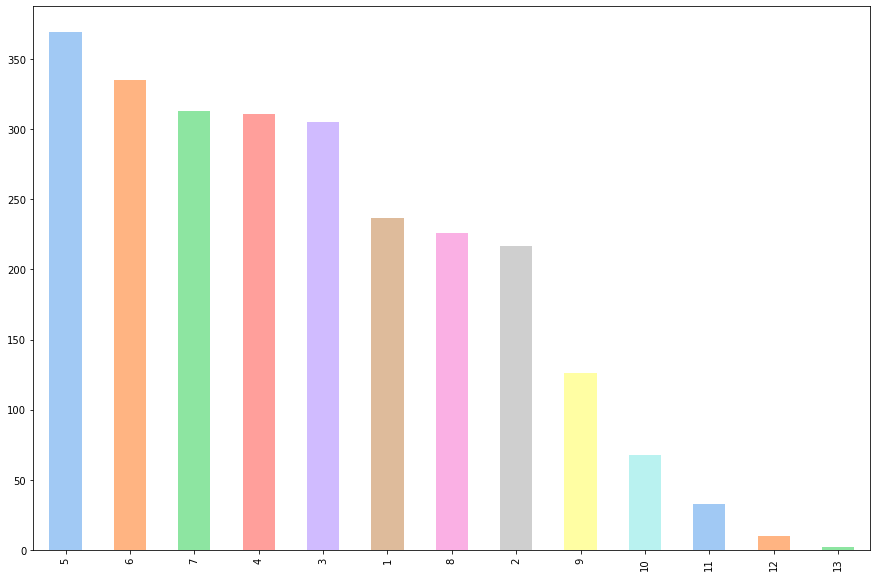

In [14]:
plt.figure(figsize=(15,10))
data['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

**character count**

In [15]:
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces
data[['correct_text','char_count']]

,correct_text,char_count
0,afraid even even damage,23
1,lord sumption recovery new initiative promote ...,72
2,timing said would put pressure brazil sanction,46
3,dying,5
4,embrace make nation us must vote,32
...,...,...
2547,one citizen call removal office legal,37
2548,today county pa,15
2549,lied fox said number covid almost nothing tell,46
2550,wasting time close election like,32


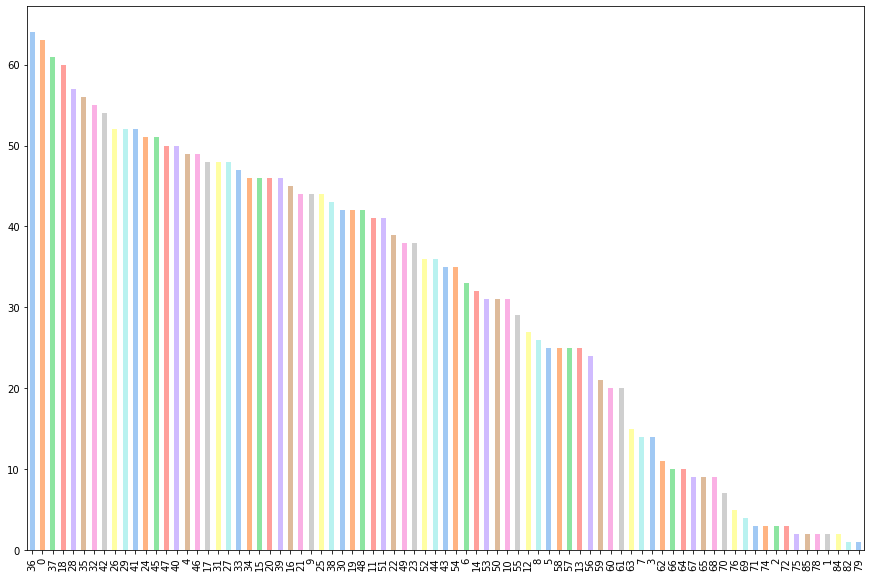

In [16]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

**average word count**

In [17]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

data['avg_word'] = data['correct_text'].apply(lambda x: avg_word(x)).round(1)
data[['correct_text','avg_word']].head()

,correct_text,avg_word
0,afraid even even damage,5.0
1,lord sumption recovery new initiative promote ...,6.3
2,timing said would put pressure brazil sanction,5.7
3,dying,5.0
4,embrace make nation us must vote,4.5


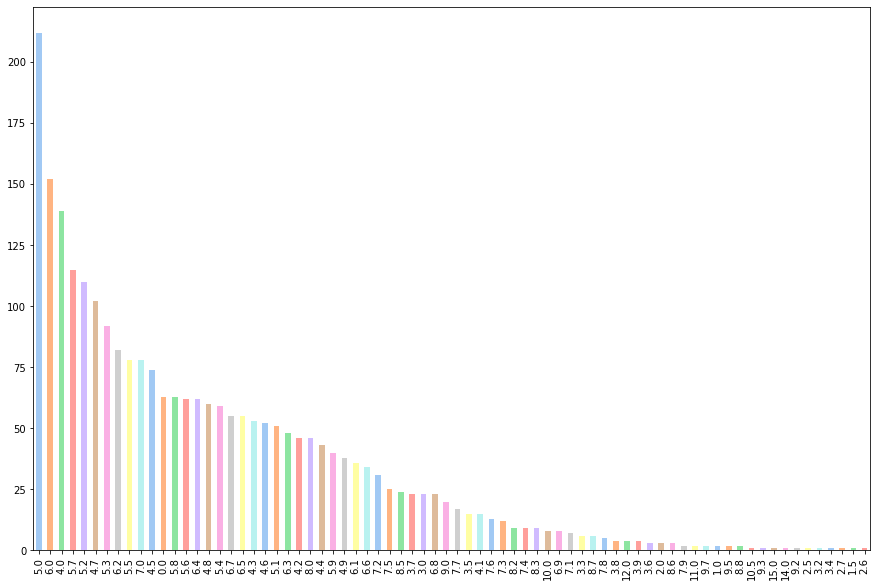

In [18]:
plt.figure(figsize=(15,10))
data['avg_word'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [51]:
final_data = data[['correct_text', 'word_count', 'char_count', 'avg_word', 'sentiment']]
final_data

,correct_text,word_count,char_count,avg_word,sentiment
0,afraid even even damage,4,23,5.0,0
1,lord sumption recovery new initiative promote ...,10,72,6.3,0
2,timing said would put pressure brazil sanction,7,46,5.7,0
3,dying,1,5,5.0,1
4,embrace make nation us must vote,6,32,4.5,1
...,...,...,...,...,...
2547,one citizen call removal office legal,6,37,5.3,1
2548,today county pa,3,15,4.3,1
2549,lied fox said number covid almost nothing tell,8,46,4.9,0
2550,wasting time close election like,5,32,5.6,0


pos = congratulations on the win
negative = the judges were stupid

## Word Clouds

Check: https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial/notebook

### Positive Tweets

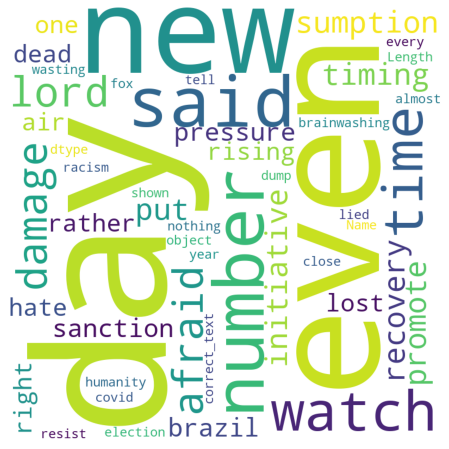

In [153]:
g = str(data[data['sentiment']==0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

### Negative Tweets

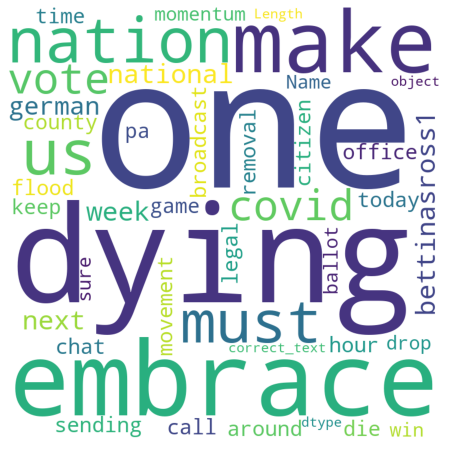

In [185]:
g = str(data[data['sentiment']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

# Corpus Assembly & Modeling

### Word Embeddings

In [54]:
X = final_data.drop(columns=['sentiment'])
y = final_data['sentiment']
# z = final.drop(columns=['correct_text', 'sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [53]:
X_train.isna().sum()

correct_text    0
word_count      0
char_count      0
avg_word        0
dtype: int64

 y-> target  
x -> text  
z -> other numerical features

In [55]:
z_train = X_train.drop(columns=['correct_text'])
z_test = X_test.drop(columns=['correct_text'])

X_train = X_train['correct_text']
X_test = X_test['correct_text']

In [56]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
X_train

2268                 instead prison due enforce death row
407                                  mother son self last
2169                                                     
807                                  buck kick trump curb
456                                           added trump
                              ...                        
599                            look recent seem desperate
1599      create complacency forget tell us get vote vote
1361    happy birthday love life one woman turns like ...
1547                                         overwhelming
863                    idiot oh yeah dick pic feather say
Name: correct_text, Length: 1709, dtype: object

In [40]:
z_test

,word_count,char_count,avg_word
1018,1,4,4.0
2117,6,42,6.2
2122,2,9,4.0
2201,3,17,5.0
2147,4,29,6.5
...,...,...,...
1211,2,14,6.5
1162,7,42,5.1
395,5,25,4.2
2355,5,26,4.4


**BagOfWords (CBOW)**


The idea is to analyze the documents. The document here refers to a unit. In case we want to find all the negative tweets during the pandemic, each tweet here is a document. To obtain the bag of words we always perform all those pre-requisite steps like cleaning, stemming, lemmatization, etc… Then we generate a set of all the words that are available before sending it for modeling. We can get repeated words within our document. A better representation is a vector form, that can tell us how many times each word can occur in a document. The following is called a document term matrix and is shown below:

<img src="https://qph.fs.quoracdn.net/main-qimg-27639a9e2f88baab88a2c575a1de2005">

row1: "Today is independence day" {"Today":0, "is": 1, "independence": 2, "day": 3}
row2: "independence day is celebrated"  {"independence":0, "day": 1, "is": 2, "celebrated": 3}
       independece
1    (value=freq=1)

In [214]:
bow = CountVectorizer(max_features=500)

In [215]:
X_train_vect = bow.fit_transform(X_train)
X_test_vect = bow.transform(X_test)

In [216]:
x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=bow.get_feature_names())
x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=bow.get_feature_names())

In [256]:
x_t1

,able,absentee,access,actually,added,afraid,ago,ahead,aid,almost,...,worst,would,wrong,year,yelling,yes,yesterday,yet,young,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
x_train = pd.concat([x_t1, z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2, z_test.reset_index(drop=True)], axis=1)

In [221]:
x_train

,able,absentee,access,actually,added,afraid,ago,ahead,aid,almost,...,yelling,yes,yesterday,yet,young,zero,index,word_count,char_count,avg_word
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2268,6,36,5.2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,407,4,20,4.2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2169,1,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,807,4,20,4.2
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,456,2,11,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,599,4,26,5.7
1705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1599,8,47,5.0
1706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1361,11,61,4.6
1707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1547,1,12,12.0


In [228]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [254]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 8.194 


In [ ]:
columns: constant value: neglect
    
    class - high frequency: more importance
        
        
        blue: 2
        bright: 3
        in each document: blue: 1/2

**Tf-Idf**

One problem that we encounter in the bag-of-words approach is that it treats every word equally, but in a document, there is a high chance of particular words being repeated more often than others. if we take each sentence as a document, we can count the number of documents each time any word occurs. This method is called document-frequency. We then divide the term frequency by the document frequency of that word. This helps us with the frequency of occurrence of terms in that document and inverse to the number of documents it appears in. Thus we have the TF-IDF. The idea is to assign particular weights to words that tell us about how important they are in the document.

<img src="https://d2mk45aasx86xg.cloudfront.net/How_word_embedding_is_done_in_TF_IDF_f8cf27a728.webp" />  


<img src="https://editor.analyticsvidhya.com/uploads/88298tfidf_ex3.png">

In [61]:
tfidf = TfidfVectorizer(stop_words='english')

In [62]:
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

In [65]:
x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=tfidf.get_feature_names())
x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=tfidf.get_feature_names())

In [69]:
x_t1

,abandon,abandoned,abject,able,abolish,abomination,abortion,absence,absentee,absolute,...,young,younger,youth,youthful,youve,yr,yuck,zero,zeta,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
x_train = pd.concat([x_t1, z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2, z_test.reset_index(drop=True)], axis=1)

In [29]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [30]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 10.530 


**Word2Vec (Skip-Gram)**

Word2Vec is widely used in most of the NLP models. It transforms the word into vectors. Word2vec is a two-layer net that processes text with words. The input is in the text corpus and the output is a set of vectors: feature vectors represent the words on that corpus.


Given enough data, usage, and conditions, Word2vec can make the most accurate predictions about the meaning of a word based on previous appearances. That guess can be used to form word-and-word combinations (eg “big” i.e. “large” to say “small” is “tiny”), or group texts and separate them by topic.


**GloVe**

GloVe – global vector for word representation. An unsupervised learning algorithm by Stanford is used to generate embedding words by combining a word matrix for the word co-occurrence of matrix from the corpus. Emerging embedded text shows an attractive line format for a word in a vector space. The GloVe model is trained in the zero-level global co-occurrence matrix, which shows how often words meet in a particular corpus.

<img src="https://editor.analyticsvidhya.com/uploads/619221_gcC7b_v7OKWutYN1NAHyMQ.png">

In [33]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass
    
    def w2v(self, corpus, size):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, size=size, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [34]:
w2v = Word_to_Vect().w2v(corpus = [sent for sent in X['correct_text']], size = len(X['correct_text']))

model's vocab gives the dictionary of words along with their vector values,  
and the values of the dictionary will give you the value of that word  

**Example**

In [35]:
w2v.wv.similar_by_vector('bad')

[('trump', 0.4643580913543701),
 ('covid', 0.43957382440567017),
 ('people', 0.41464903950691223),
 ('us', 0.4014951288700104),
 ('get', 0.39459118247032166),
 ('like', 0.3792682886123657),
 ('many', 0.3768415153026581),
 ('new', 0.37580370903015137),
 ('man', 0.3708970844745636),
 ('election', 0.3694921135902405)]

***We can create the document-term matrix by creating a dictionary with `"word": "value"`, using the below function***

In [37]:
X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X['correct_text'] for word in sent.split()})
X_w2v

,afraid,even,damage,lord,sumption,recovery,new,initiative,promote,deal,...,rent,drlimengyan1,pneumonia,erased,wishful,epidemic,click,wherever,younger,brainwashing
0,-0.000014,-0.000001,0.000136,0.000020,-0.000095,0.000128,-0.000051,0.000121,0.000187,-0.000149,...,0.000099,-0.000003,0.000068,0.000094,-0.000139,0.000054,0.000123,0.000099,0.000025,0.000175
1,0.000097,0.000057,-0.000123,-0.000179,-0.000150,-0.000040,0.000002,-0.000037,0.000192,-0.000179,...,-0.000052,-0.000044,-0.000059,0.000020,0.000116,-0.000083,-0.000071,0.000138,0.000074,-0.000088
2,-0.000064,-0.000289,0.000080,-0.000039,-0.000099,0.000176,-0.000122,-0.000201,0.000097,-0.000122,...,0.000029,0.000019,0.000001,0.000137,-0.000135,0.000039,-0.000194,-0.000152,-0.000032,0.000185
3,0.000044,0.000074,-0.000121,-0.000022,-0.000088,-0.000047,-0.000131,0.000019,-0.000068,-0.000141,...,0.000125,-0.000195,0.000046,-0.000182,-0.000182,-0.000036,0.000092,-0.000072,-0.000104,-0.000183
4,-0.000070,0.000110,-0.000102,0.000141,-0.000087,-0.000019,0.000090,0.000045,0.000144,0.000191,...,0.000024,-0.000058,0.000167,-0.000078,0.000126,0.000103,0.000003,0.000077,-0.000156,-0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,0.000020,0.000078,-0.000100,0.000046,-0.000080,-0.000100,0.000158,0.000148,-0.000085,-0.000072,...,-0.000010,0.000075,0.000036,-0.000008,0.000192,-0.000018,-0.000096,0.000131,-0.000007,-0.000121
2548,-0.000169,0.000025,-0.000012,-0.000031,0.000019,0.000110,0.000267,0.000149,0.000067,0.000123,...,0.000060,0.000153,0.000076,-0.000042,-0.000068,-0.000023,-0.000088,-0.000020,0.000065,0.000006
2549,-0.000028,-0.000076,-0.000110,-0.000010,0.000117,0.000036,0.000052,-0.000163,-0.000184,-0.000048,...,0.000142,0.000177,0.000057,0.000147,-0.000135,0.000078,0.000089,0.000010,0.000087,0.000120
2550,-0.000016,0.000173,0.000188,-0.000015,-0.000036,0.000055,0.000100,-0.000172,0.000032,-0.000086,...,-0.000173,0.000140,0.000153,0.000039,-0.000125,0.000091,-0.000075,0.000118,-0.000156,0.000197


In [38]:
x_t1, x_t2, _, _ = train_test_split(X_w2v, y, test_size=0.33, random_state=101)

In [39]:
x_t2

,afraid,even,damage,lord,sumption,recovery,new,initiative,promote,deal,...,rent,drlimengyan1,pneumonia,erased,wishful,epidemic,click,wherever,younger,brainwashing
1018,-0.000046,0.000251,-0.000016,0.000031,0.000009,-0.000175,3.567776e-04,0.000174,1.653559e-04,-0.000118,...,-0.000145,-0.000180,0.000002,0.000037,-0.000158,-0.000099,-0.000186,0.000149,-0.000052,-0.000100
2117,0.000123,0.000183,-0.000016,0.000098,-0.000178,-0.000070,3.148946e-05,0.000092,-1.398799e-04,-0.000092,...,0.000010,0.000034,-0.000191,0.000096,0.000038,-0.000169,0.000154,-0.000054,-0.000054,-0.000065
2122,-0.000031,-0.000237,0.000159,-0.000033,0.000132,0.000033,-2.211958e-04,-0.000168,4.510279e-05,-0.000176,...,0.000146,-0.000167,0.000087,0.000184,0.000085,0.000141,-0.000009,0.000081,0.000145,-0.000088
2201,0.000066,-0.000126,0.000001,-0.000143,0.000113,-0.000128,-5.120810e-09,0.000150,-2.376292e-05,0.000113,...,-0.000113,0.000143,0.000040,-0.000111,-0.000131,-0.000008,-0.000178,-0.000006,0.000119,0.000194
2147,0.000100,0.000099,0.000032,-0.000074,-0.000097,0.000111,-8.794261e-05,-0.000015,-7.050798e-07,0.000187,...,-0.000116,-0.000050,-0.000127,-0.000161,-0.000127,0.000088,-0.000003,-0.000190,-0.000153,-0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,-0.000086,0.000075,-0.000080,0.000131,0.000087,-0.000044,2.664547e-04,0.000010,1.274988e-04,0.000069,...,0.000052,0.000060,0.000154,-0.000177,-0.000138,-0.000129,0.000035,-0.000162,0.000060,0.000057
1162,-0.000137,-0.000003,0.000112,-0.000194,0.000153,-0.000055,-4.776164e-04,-0.000140,1.359133e-04,-0.000065,...,-0.000175,-0.000189,0.000001,0.000035,-0.000012,0.000179,-0.000131,-0.000077,-0.000008,0.000175
395,-0.000113,0.000070,0.000161,0.000096,-0.000117,-0.000081,-7.428045e-05,-0.000189,1.505166e-04,0.000056,...,-0.000163,0.000147,0.000185,0.000029,-0.000143,0.000183,-0.000082,0.000015,0.000003,-0.000010
2355,-0.000142,-0.000082,-0.000012,0.000038,0.000088,0.000129,1.691388e-05,0.000137,1.778394e-05,-0.000093,...,0.000086,-0.000020,-0.000148,-0.000117,0.000110,-0.000163,0.000108,-0.000171,-0.000084,-0.000019


In [40]:
x_train = pd.concat([x_t1.reset_index(drop=True), z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2.reset_index(drop=True), z_test.reset_index(drop=True)], axis=1)

In [41]:
clf = XGBClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

d:\softwares\python3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\softwares\python3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [45]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 16.102 


# Modelling


1. ML Algorithms
2. DL Neural Networks

**Machine leaning**

In [25]:
rf = RandomForestClassifier(n_estimators=500, bootstrap=True, min_samples_split=5)
rf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=500)

In [26]:
y_pred_ml = rf.predict(x_test)
print("logloss: %0.3f " % log_loss(y_pred_ml, pred))

logloss: 7.129 


**Deep learning**

In [92]:
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(x_train.shape[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                120900    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 120,951
Trainable params: 120,951
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.fit(np.asarray(x_train), np.asarray(y_train), epochs=50, batch_size=50)
# evaluate
loss, acc = model.evaluate(np.asarray(x_test), np.asarray(y_test))
print('Test Accuracy: %f' % (acc*100))

Train on 1709 samples
Epoch 1/50
1709/1709 [==============================] - 0s 224us/sample - loss: 0.6945 - acc: 0.5535
Epoch 2/50
1709/1709 [==============================] - 0s 131us/sample - loss: 0.6624 - acc: 0.6202
Epoch 3/50
1709/1709 [==============================] - 0s 152us/sample - loss: 0.6355 - acc: 0.6782
Epoch 4/50
1709/1709 [==============================] - 0s 154us/sample - loss: 0.6120 - acc: 0.7150
Epoch 5/50
1709/1709 [==============================] - 0s 162us/sample - loss: 0.5873 - acc: 0.7384
Epoch 6/50
1709/1709 [==============================] - 0s 192us/sample - loss: 0.5608 - acc: 0.7800
Epoch 7/50
1709/1709 [==============================] - 0s 180us/sample - loss: 0.5295 - acc: 0.8327
Epoch 8/50
1709/1709 [==============================] - 0s 179us/sample - loss: 0.5021 - acc: 0.8444
Epoch 9/50
1709/1709 [==============================] - 0s 184us/sample - loss: 0.4696 - acc: 0.8683
Epoch 10/50
1709/1709 [==============================] - 0s 189us/sam

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [81]:
y_pred_dl = model.predict(x_test)

print("logloss: %0.3f " % log_loss(y_test, y_pred_dl.round(), eps=1e-7))

logloss: 4.562 


**Transformer pretrained model from distilBERT**

In [82]:
tokenizer_name = "distilbert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [83]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)
trn = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cpu()
pipe = TextClassificationPipeline(model=trn, tokenizer=tokenizer, return_all_scores=True)

In [84]:
print(X_test[1162])
pipe([X_test[1162]])

get money someone covid trump sad ignorant


[[{'label': 'NEGATIVE', 'score': 0.9983728528022766},
  {'label': 'POSITIVE', 'score': 0.0016271244967356324}]]

# Shap with NLP

In [98]:
shap.initjs()

In [85]:
def get_parse_text(text):
    sample = text
    sample = clean_text(sample)
    return correct_text(sample)

def get_numerical_features(text):
    word_count = len(text.split())
    char_count = len(text)
    sample = text.split()
    avg_word = (sum(len(word) for word in sample)/(len(sample)+0.000001))
    return (word_count, char_count, avg_word)

def pipe_text(text):
    embedding = tfidf.transform([text]).toarray()[0]
    num = get_numerical_features(text)
    cluster = np.concatenate([embedding, num])
    value = np.array([cluster])
    
    return value

In [95]:
explainer = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), np.asarray(x_test[:100]))
shap_values = explainer.shap_values(np.asarray(x_test[:100]))

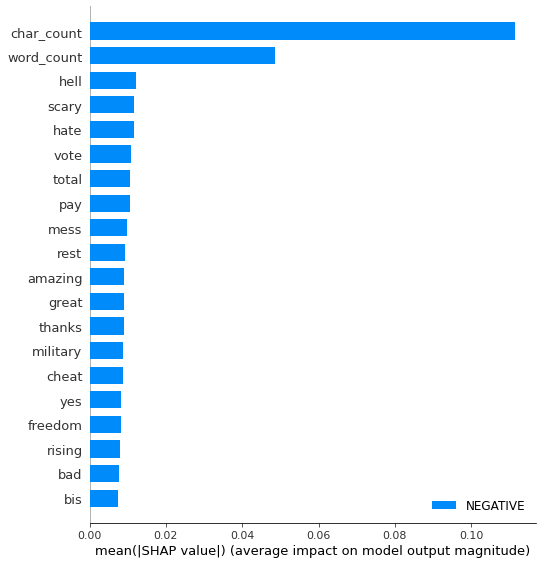

In [96]:
shap.summary_plot(shap_values, feature_names= x_test.columns, class_names=["NEGATIVE", "POSITIVE"])

In [99]:
shap.force_plot(explainer.expected_value[0],shap_values[0][3], feature_names=x_train.columns)

### Get user input for text and plot the sentiment

In [102]:
def score_custom_force_plot(text):
    sample = get_parse_text(text)
    arr = pipe_text(sample)
    
    pred = model.predict(arr).round()
    print(pred)
    sh = explainer.shap_values(pipe_text(text))
    
    return shap.force_plot(explainer.expected_value[0], sh[0], feature_names=x_train.columns)

In [103]:
score_custom_force_plot(input("Tweet your thoughts here: "))

Tweet your thoughts here: @DonaldTrump you have no chance this year
[[1.]]


In [250]:
def visualize_transformer(text):
    prediction = pipe([text])
    print(prediction[0])

    explainer = shap.Explainer(pipe)
    shap_transformer = explainer([text])

    shap.plots.text(shap_transformer)
    shap.plots.text(shap_transformer[0,:,"POSITIVE"])

In [252]:
visualize_transformer('@JoeBiden Trump needs to build back better')

[{'label': 'NEGATIVE', 'score': 0.9982820749282837}, {'label': 'POSITIVE', 'score': 0.0017179388087242842}]


,,@,JoeBiden,Trump needs,to build,back better,
NEGATIVE,0.0,0.346,1.354,2.933,1.132,-0.234,0.0
POSITIVE,-0.0,-0.346,-1.354,-2.933,-1.132,0.234,0.0


https://www.fast.ai/2019/07/08/fastai-nlp/  
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e  
https://ruder.io/deep-learning-nlp-best-practices/index.html  

colorcode and visualize: https://sararobinson.dev/2019/04/23/interpret-bag-of-words-models-shap.html   
https://coderzcolumn.com/tutorials/artificial-intelligence/shap-values-for-text-classification-tasks